# Stroke Prediction Model

## 1. Importing libraries

In [1]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql as sparksql
from pyspark.context import SparkContext
sc = SparkContext('local')
spark = SparkSession.builder.appName('stroke').getOrCreate()
#sc = SparkSession.builder.appName('stroke-prediction').getOrCreate(

In [3]:
from pyspark.sql.functions import when, col
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import StringIndexer

In [4]:
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression,GBTClassifier,LinearSVC, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [5]:
from pyspark.ml.classification import DecisionTreeClassificationModel

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [8]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix

## 2. Load data

In [10]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
data = spark.read.csv('gdrive/My Drive/Data Science/00 Projects/08_Stroke/01/dataset.csv', inferSchema=True,header=True)

In [12]:
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [13]:
data.show(5)

+-----+------+----+------------+-------------+------------+------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|   work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+------------+--------------+-----------------+----+---------------+------+
|30669|  Male| 3.0|           0|            0|          No|    children|         Rural|            95.12|18.0|           null|     0|
|30468|  Male|58.0|           1|            0|         Yes|     Private|         Urban|            87.96|39.2|   never smoked|     0|
|16523|Female| 8.0|           0|            0|          No|     Private|         Urban|           110.89|17.6|           null|     0|
|56543|Female|70.0|           0|            0|         Yes|     Private|         Rural|            69.04|35.9|formerly smoked|     0|
|46136|  Male|14.0|           0|            0|          No|Nev

## 3. Analysis

In [14]:
dataPandas = data.toPandas()

In [15]:
dataPandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int32  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int32  
 4   heart_disease      43400 non-null  int32  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int32  
dtypes: float64(3), int32(4), object(5)
memory usage: 3.3+ MB


In [16]:
dataPandas.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,36326.142350,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,21072.134879,22.519649,0.291235,0.212733,43.111751,7.770020,0.133103
min,1.000000,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,18038.500000,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,36351.500000,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,54514.250000,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,72943.000000,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


### 3.1 ID

ID is a unique number assigned to every patient. There is no need for analysis. I'll remove it.

In [17]:
dataPandas.drop("id",inplace=True,axis=1)

### 3.2 Gender


In [18]:
print('Unique values : ',dataPandas['gender'].unique())
print('Value    Counts')
print(dataPandas['gender'].value_counts())

Unique values :  ['Male' 'Female' 'Other']
Value    Counts
Female    25665
Male      17724
Other        11
Name: gender, dtype: int64


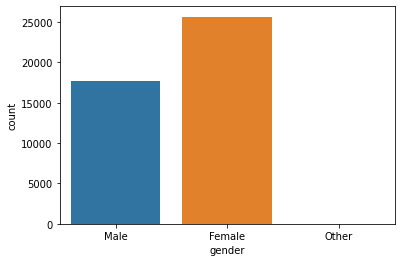

In [19]:
sns.countplot(data=dataPandas,x='gender')

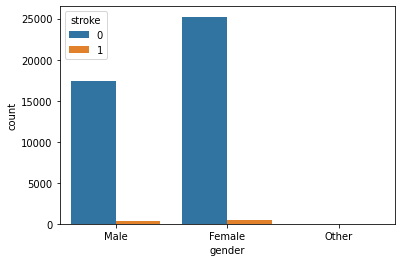

In [20]:
sns.countplot(data=dataPandas,x='gender',hue='stroke')

It can be seen that the dataset is imbalanced. There is no gender correlationwith stroke

### 3.3 Age

In [21]:
dataPandas['age'].nunique()

104

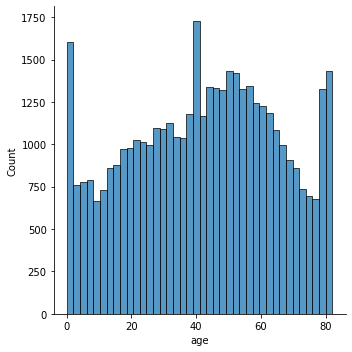

In [22]:
sns.displot(dataPandas['age'])

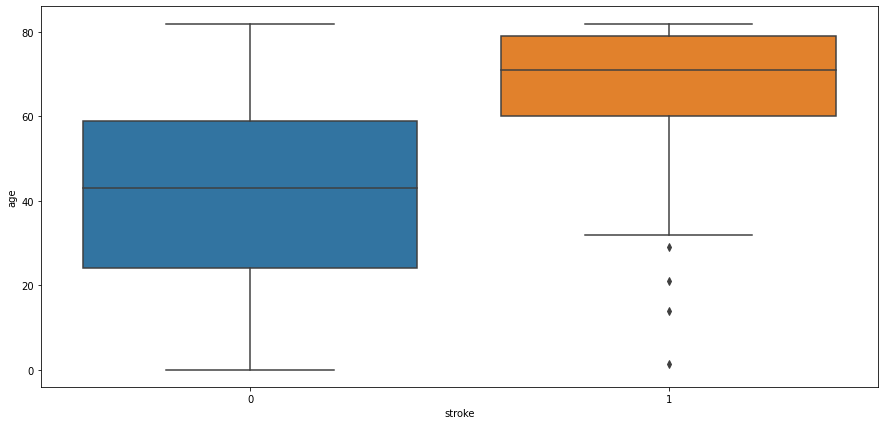

In [23]:
plt.figure(figsize=(15,7))
sns.boxplot(data=dataPandas,x='stroke',y='age')

People over 60 years old are at increased risk of having a stroke 

### 3.4 Hypertension

In [24]:
print('Unique values : ',dataPandas['hypertension'].unique())

Unique values :  [0 1]


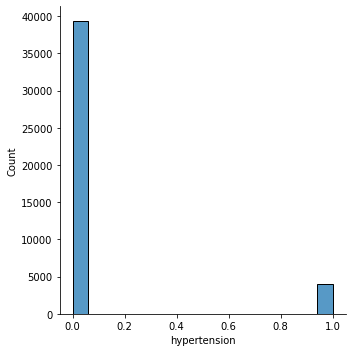

In [25]:
sns.displot(dataPandas['hypertension'])

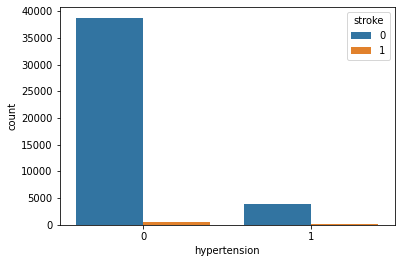

In [26]:
sns.countplot(data=dataPandas,x='hypertension',hue='stroke')

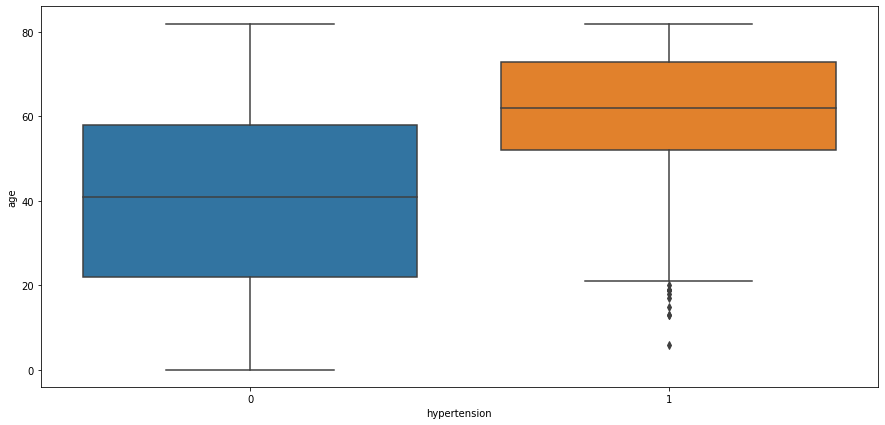

In [27]:
plt.figure(figsize=(15,7))
sns.boxplot(data=dataPandas,x='hypertension',y='age')

We can see hypertension is rare in young people and common in aged people. Based on the data, it's not clear that hypertension causes a stroke. There are not enough cases of hypertension.

### 3.5 Heart disease

In [28]:
print('Unique values : ',dataPandas['heart_disease'].unique())
print('Value    Counts')
print(dataPandas['heart_disease'].value_counts())

Unique values :  [0 1]
Value    Counts
0    41338
1     2062
Name: heart_disease, dtype: int64


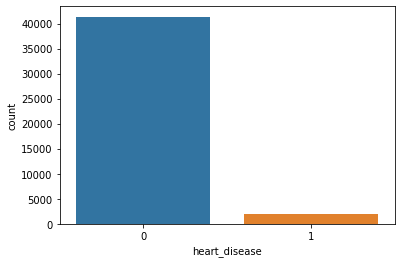

In [29]:
sns.countplot(data=dataPandas,x='heart_disease')

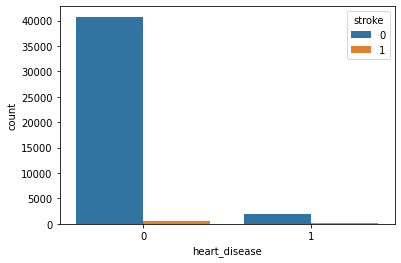

In [30]:
sns.countplot(data=dataPandas,x='heart_disease',hue='stroke')

Based on the data, it's not clear that heart disease causes a stroke. There are not enough cases of heart disease.

### 3.6 Ever married

In [31]:
print('Unique values : ',dataPandas['ever_married'].unique())
print('Value    Counts')
print(dataPandas['ever_married'].value_counts())

Unique values :  ['No' 'Yes']
Value    Counts
Yes    27938
No     15462
Name: ever_married, dtype: int64


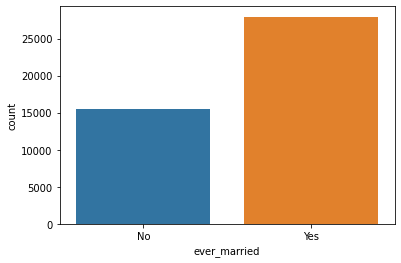

In [32]:
sns.countplot(data=dataPandas,x='ever_married')

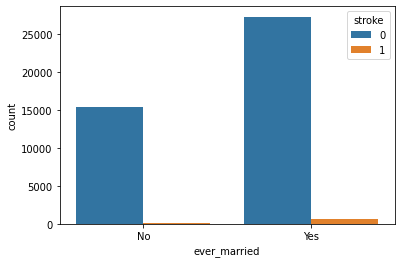

In [33]:
sns.countplot(data=dataPandas,x='ever_married',hue='stroke')

Married people have a higher risk of having a stroke.

### 3.7 Work type

In [34]:
print('Unique values : ',dataPandas['work_type'].unique())
print('Value    Counts')
print(dataPandas['work_type'].value_counts())

Unique values :  ['children' 'Private' 'Never_worked' 'Self-employed' 'Govt_job']
Value    Counts
Private          24834
Self-employed     6793
children          6156
Govt_job          5440
Never_worked       177
Name: work_type, dtype: int64


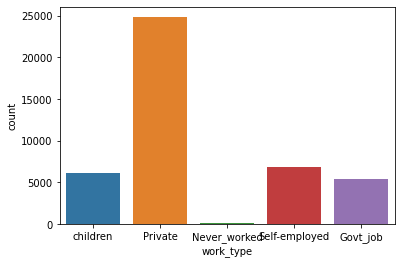

In [35]:
sns.countplot(data=dataPandas,x='work_type')

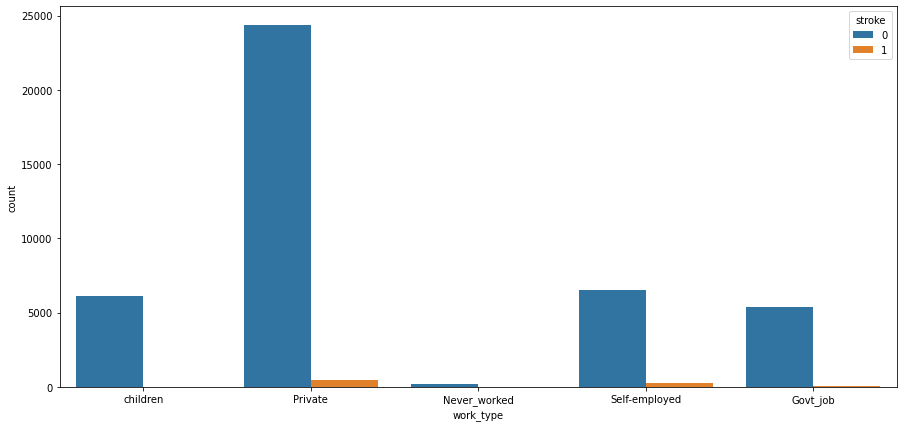

In [36]:
plt.figure(figsize=(15,7))
sns.countplot(data=dataPandas,x='work_type',hue='stroke')

People working in the private sector and self employed have the higher risk of stroke.

### 3.8 Residence type

In [37]:
print('Unique values : ',dataPandas['Residence_type'].unique())
print('Value    Counts')
print(dataPandas['Residence_type'].value_counts())

Unique values :  ['Rural' 'Urban']
Value    Counts
Urban    21756
Rural    21644
Name: Residence_type, dtype: int64


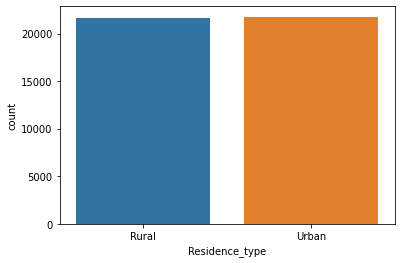

In [38]:
sns.countplot(data=dataPandas,x='Residence_type')

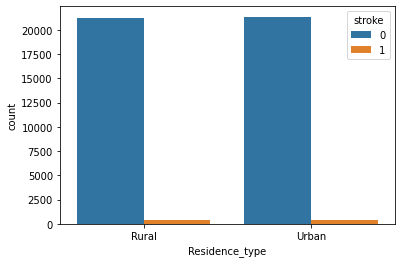

In [39]:
sns.countplot(data=dataPandas,x='Residence_type',hue='stroke')

Residence type has no correlation with stroke. 


### 3.9 Average Glucose Level

In [40]:
dataPandas['avg_glucose_level'].nunique()

12543

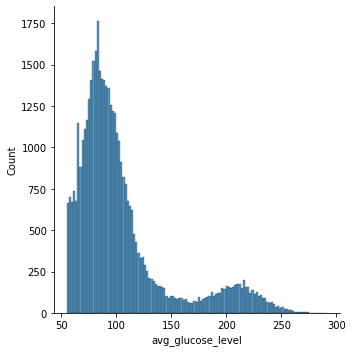

In [41]:
sns.displot(dataPandas['avg_glucose_level'])

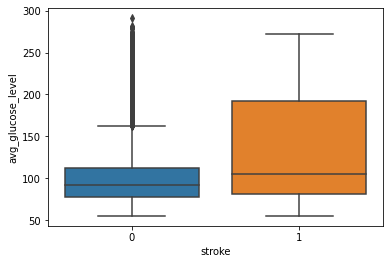

In [42]:
sns.boxplot(data=dataPandas,x='stroke',y='avg_glucose_level')

From graph above, we can see that people having stroke have an average glucose level of more than 100.

### 3.10 BMI

In [43]:
dataPandas['bmi'].isna().sum()

1462

In [44]:
dataPandas['bmi'].fillna(dataPandas['bmi'].mean(),inplace=True)

In [45]:
dataPandas['bmi'].nunique()

556

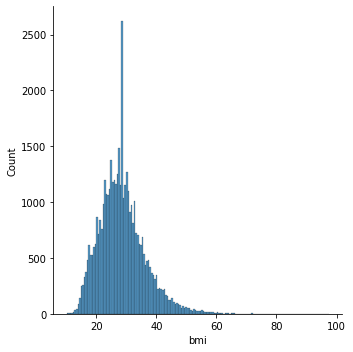

In [46]:
sns.displot(dataPandas['bmi'])

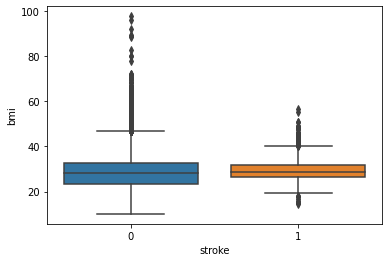

In [47]:
sns.boxplot(data=dataPandas,x='stroke',y='bmi')

There is no observations which can confirm does BMI affects the chances of having a stroke.

### 3.11 Smoking status

In [48]:
print('Unique values : ',dataPandas['smoking_status'].unique())
print('Value    Counts')
print(dataPandas['smoking_status'].value_counts())

Unique values :  [None 'never smoked' 'formerly smoked' 'smokes']
Value    Counts
never smoked       16053
formerly smoked     7493
smokes              6562
Name: smoking_status, dtype: int64


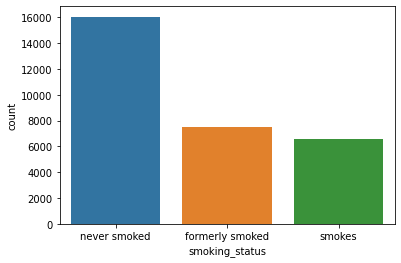

In [49]:
sns.countplot(data=dataPandas,x='smoking_status')

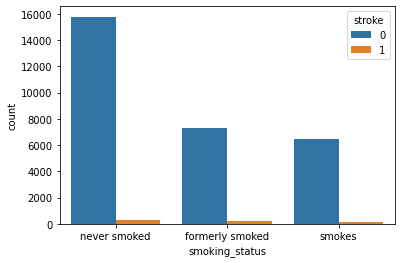

In [50]:
sns.countplot(data=dataPandas,x='smoking_status',hue='stroke')

There is not much difference in the chances of stroke depend on smoking status.

### 3.12 Stroke
Our target variable. It tells us whether patients have chances of stroke.

In [51]:
print('Unique values : ',dataPandas['stroke'].unique())
print('Value    Counts')
print(dataPandas['stroke'].value_counts())

Unique values :  [0 1]
Value    Counts
0    42617
1      783
Name: stroke, dtype: int64


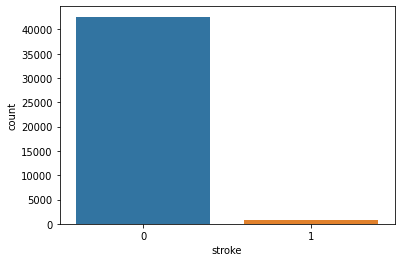

In [52]:
sns.countplot(data=dataPandas,x='stroke')

Remove empty row

In [53]:
dataPandas.dropna(subset = ['smoking_status'], inplace = True)
dataPandas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30108 entries, 1 to 43399
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             30108 non-null  object 
 1   age                30108 non-null  float64
 2   hypertension       30108 non-null  int32  
 3   heart_disease      30108 non-null  int32  
 4   ever_married       30108 non-null  object 
 5   work_type          30108 non-null  object 
 6   Residence_type     30108 non-null  object 
 7   avg_glucose_level  30108 non-null  float64
 8   bmi                30108 non-null  float64
 9   smoking_status     30108 non-null  object 
 10  stroke             30108 non-null  int32  
dtypes: float64(3), int32(3), object(5)
memory usage: 2.4+ MB


## 4. Feature Engineering

In [54]:
cols=dataPandas.select_dtypes(include=['object']).columns
print(cols)
le=LabelEncoder()
dataPandas[cols]=dataPandas[cols].apply(le.fit_transform)
dataPandas.head(10)

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,1,58.0,1,0,1,2,1,87.96,39.2,1,0
3,0,70.0,0,0,1,2,0,69.04,35.9,0,0
6,0,52.0,0,0,1,2,1,77.59,17.7,0,0
7,0,75.0,0,1,1,3,0,243.53,27.0,1,0
8,0,32.0,0,0,1,2,0,77.67,32.3,2,0
9,0,74.0,1,0,1,3,1,205.84,54.6,1,0
11,1,79.0,0,1,1,2,1,57.08,22.0,0,0
12,0,37.0,0,0,1,2,0,162.96,39.4,1,0
13,0,37.0,0,0,1,2,0,73.50,26.1,0,0
14,0,40.0,0,0,1,2,0,95.04,42.4,1,0


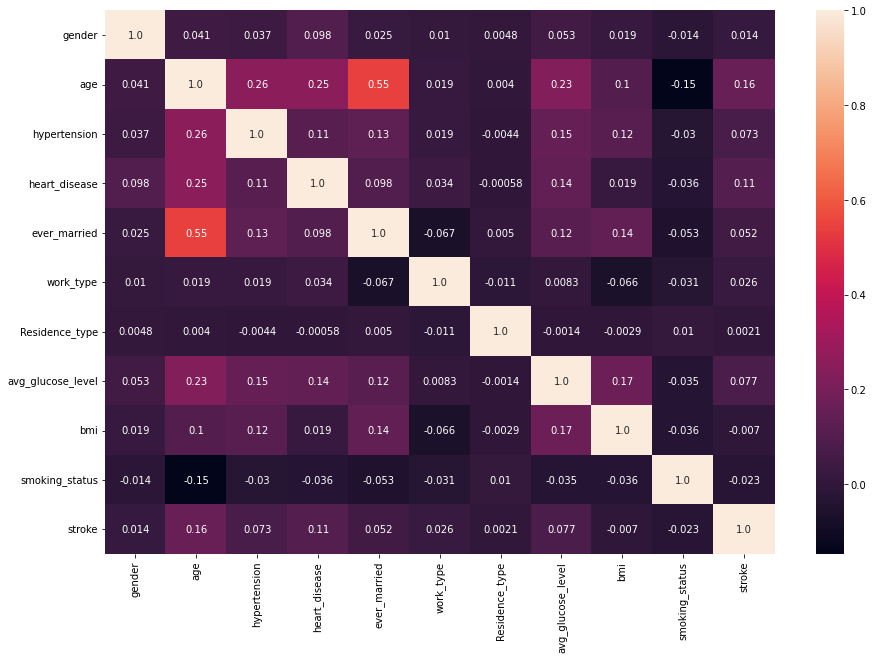

In [55]:
plt.figure(figsize=(15,10))
sns.heatmap(dataPandas.corr(),annot=True,fmt='.2')

Variables that are showing some effective correlation are:

age, hypertension, heart_disease, ever_married, avg_glucose_level, BMI

In [56]:
classifier = SelectKBest(score_func=f_classif,k=5)
fits = classifier.fit(dataPandas.drop('stroke',axis=1),dataPandas['stroke'])
x=pd.DataFrame(fits.scores_)
columns = pd.DataFrame(dataPandas.drop('stroke',axis=1).columns)
fscores = pd.concat([columns,x],axis=1)
fscores.columns = ['Attribute','Score']
fscores.sort_values(by='Score',ascending=False)

,Attribute,Score
1,age,789.315878
3,heart_disease,348.721949
7,avg_glucose_level,180.528942
2,hypertension,162.673707
4,ever_married,80.578562
5,work_type,19.909786
9,smoking_status,16.029023
0,gender,5.642641
8,bmi,1.454446
6,Residence_type,0.128225


In the above result, we can see that age is a highly correlated variable and then it gets decreasing. I am keeping the threshold score as 80. Resulting in the same features we got in the heatmap.

In [57]:
cols=fscores[fscores['Score']>50]['Attribute']
print(cols)

1                  age
2         hypertension
3        heart_disease
4         ever_married
7    avg_glucose_level
Name: Attribute, dtype: object


## 5. Splitting data

Now, let’s split features into training and testing sets for training and testing our classification models.

In [58]:
train_x,test_x,train_y,test_y=train_test_split(dataPandas[cols],dataPandas['stroke'],random_state=1255,test_size=0.25)
train_x.shape,test_x.shape,train_y.shape,test_y.shape

((22581, 5), (7527, 5), (22581,), (7527,))

In [59]:
type(train_y)

pandas.core.series.Series

In [60]:
train_y.value_counts()

0    22089
1      492
Name: stroke, dtype: int64

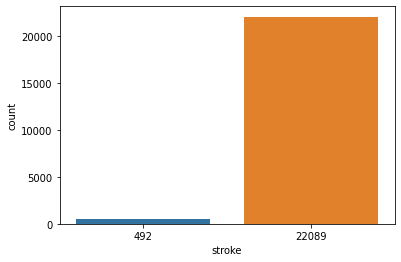

In [61]:
sns.countplot(data=train_y.value_counts(),x=train_y)

## 6. Balancing Dataset

In [62]:
smote=SMOTE()
train_x,train_y=smote.fit_resample(train_x,train_y)

In [63]:
print(train_x.shape,train_y.shape)

(44178, 5) (44178,)


In [64]:
train_y.value_counts()

0    22089
1    22089
Name: stroke, dtype: int64

Combining Resampled Data into One Spark Dataframe

In [65]:
dataframe_1 = pd.DataFrame(train_x,columns=['age','hypertension','heart_disease','ever_married','avg_glucose_level'])
dataframe_2 = pd.DataFrame(train_y, columns = ['stroke'])
result = dataframe_1.combine_first(dataframe_2)
result.head(2)

,age,avg_glucose_level,ever_married,heart_disease,hypertension,stroke
0,40.0,78.08,0,0,0,0
1,59.0,88.29,1,0,1,0


In [66]:
dataframe_3 = pd.DataFrame(test_x,columns=['age','hypertension','heart_disease','ever_married','avg_glucose_level'])
dataframe_4 = pd.DataFrame(test_y, columns = ['stroke'])
result_2 = dataframe_3.combine_first(dataframe_4)
result_2.head(2)

,age,avg_glucose_level,ever_married,heart_disease,hypertension,stroke
20443,50.0,179.65,1,0,0,0
31709,20.0,58.19,0,0,0,0


In [67]:
dataSpark = spark.createDataFrame(result)

In [68]:
dataSpark_2 = spark.createDataFrame(result_2)

In [69]:
dataSpark.printSchema()

root
 |-- age: double (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- ever_married: long (nullable = true)
 |-- heart_disease: long (nullable = true)
 |-- hypertension: long (nullable = true)
 |-- stroke: long (nullable = true)



In [70]:
dataSpark_2.printSchema()

root
 |-- age: double (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- ever_married: long (nullable = true)
 |-- heart_disease: long (nullable = true)
 |-- hypertension: long (nullable = true)
 |-- stroke: long (nullable = true)



In [71]:
dataSpark = dataSpark.withColumnRenamed('stroke','label')

In [72]:
dataSpark_2 = dataSpark.withColumnRenamed('stroke','label')

In [73]:
dataSpark.printSchema()

root
 |-- age: double (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- ever_married: long (nullable = true)
 |-- heart_disease: long (nullable = true)
 |-- hypertension: long (nullable = true)
 |-- label: long (nullable = true)



In [74]:
dataSpark_2.printSchema()

root
 |-- age: double (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- ever_married: long (nullable = true)
 |-- heart_disease: long (nullable = true)
 |-- hypertension: long (nullable = true)
 |-- label: long (nullable = true)



## 7. Model creation

In [75]:
assembler = VectorAssembler(inputCols=['age','hypertension','heart_disease','ever_married','avg_glucose_level'],outputCol='features')

In [76]:
pipeline = Pipeline(stages = [assembler])
pipelineModel = pipeline.fit(dataSpark)
df = pipelineModel.transform(dataSpark)
selectedCols = ['label', 'features','age','hypertension','heart_disease','ever_married','avg_glucose_level']
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: long (nullable = true)
 |-- features: vector (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: long (nullable = true)
 |-- heart_disease: long (nullable = true)
 |-- ever_married: long (nullable = true)
 |-- avg_glucose_level: double (nullable = true)



In [77]:
va = VectorAssembler(inputCols = ['age','hypertension','heart_disease','ever_married','avg_glucose_level'], outputCol='features')

In [78]:
va_df = va.transform(dataSpark)

In [79]:
va_df = va_df.select(['features', 'label'])
va_df.show(3)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(5,[0,4],[40.0,78...|    0|
|[59.0,1.0,0.0,1.0...|    0|
|[61.0,0.0,0.0,1.0...|    0|
+--------------------+-----+
only showing top 3 rows



In [80]:
va_df_2 = va.transform(dataSpark_2)
va_df_2 = va_df_2.select(['features', 'label'])
va_df_2.show(3)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(5,[0,4],[40.0,78...|    0|
|[59.0,1.0,0.0,1.0...|    0|
|[61.0,0.0,0.0,1.0...|    0|
+--------------------+-----+
only showing top 3 rows



In [81]:
(train, test) = va_df.randomSplit([0.8, 0.2])

### 7.1 Decision tree classifier model

In [82]:
dtc = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtcModel = dtc.fit(train)
predictions = dtcModel.transform(va_df_2)
predictions.show(3)

+--------------------+-----+---------------+--------------------+----------+
|            features|label|  rawPrediction|         probability|prediction|
+--------------------+-----+---------------+--------------------+----------+
|(5,[0,4],[40.0,78...|    0|[9723.0,1461.0]|[0.86936695278969...|       0.0|
|[59.0,1.0,0.0,1.0...|    0|[4016.0,2947.0]|[0.57676288955909...|       0.0|
|[61.0,0.0,0.0,1.0...|    0|[4016.0,2947.0]|[0.57676288955909...|       0.0|
+--------------------+-----+---------------+--------------------+----------+
only showing top 3 rows



In [83]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7879571516232343


### 7.2 Logistic Regression Model

In [84]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

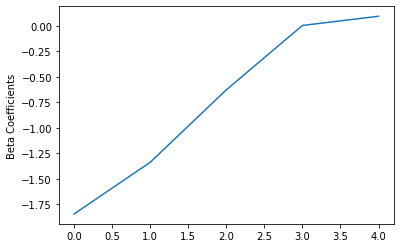

In [85]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

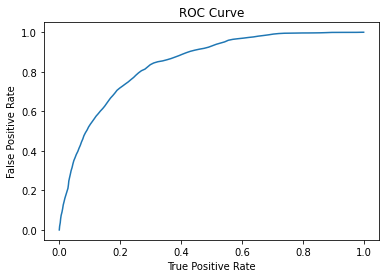

Training set areaUnderROC: 0.8426660709394619


In [86]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

Precision and recall


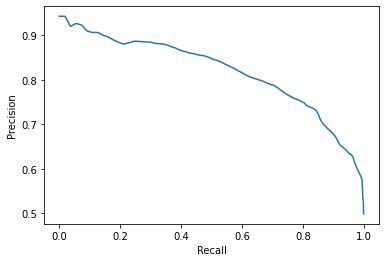

In [87]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Make predictions on the test set

In [88]:
predictions = lrModel.transform(va_df_2)
predictions.show(3)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(5,[0,4],[40.0,78...|    0|[0.42421809284678...|[0.60449216054805...|       0.0|
|[59.0,1.0,0.0,1.0...|    0|[1.78004744975854...|[0.85570272489442...|       0.0|
|[61.0,0.0,0.0,1.0...|    0|[-0.1624992683321...|[0.45946434244093...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 3 rows



Evaluate our Logistic Regression model

In [89]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8429387949602092


### 7.3 Random forest classifier


In [90]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(va_df_2)
predictions.show(3)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(5,[0,4],[40.0,78...|    0|[18.2830873597596...|[0.91415436798798...|       0.0|
|[59.0,1.0,0.0,1.0...|    0|[13.1326505383428...|[0.65663252691714...|       0.0|
|[61.0,0.0,0.0,1.0...|    0|[10.2441081071499...|[0.51220540535749...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 3 rows



Evaluate Random Forest Classifier

In [91]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8587779077140184


### 7.4 Gradient-Boosted Tree Classifier

In [92]:
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(va_df_2)
predictions.show(3)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(5,[0,4],[40.0,78...|    0|[0.94916459097858...|[0.86970230511941...|       0.0|
|[59.0,1.0,0.0,1.0...|    0|[0.60553699955044...|[0.77048892564441...|       0.0|
|[61.0,0.0,0.0,1.0...|    0|[0.17318882023549...|[0.58573889143151...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 3 rows



Evaluate Gradient-Boosted Tree Classifier

In [93]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8760279146059742


In [94]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [95]:
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)# Cross validation can take about few minutes
cvModel = cv.fit(train)
predictions = cvModel.transform(va_df_2)
evaluator.evaluate(predictions)

0.911697178298418

## 8. Save model

In [99]:
basePath = "gdrive/My Drive/Data Science/00 Projects/08_Stroke"
cvModel.save(basePath + "/cvModel01")

## 9. Test some data

In [100]:
model_in = CrossValidatorModel.load('gdrive/My Drive/Data Science/00 Projects/08_Stroke/cvModel01')

In [101]:
featureColumns = ['age', 'hypertension','heart_disease', 'ever_married', 'avg_glucose_level']


In [102]:
def predict2(age, hypertension, heart_disease, ever_married, avg_glucose_level):
    predictDf = pd.DataFrame(np.array([[age, hypertension, heart_disease, ever_married, avg_glucose_level]]), columns=featureColumns)
    sparkPredictDf = spark.createDataFrame(predictDf)
    predictAssembler = VectorAssembler(inputCols=['age', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level'], outputCol='features')
    predictAssembled = predictAssembler.transform(sparkPredictDf)
    predictAssembled = predictAssembled.select(['features'])
    predictedDf = model_in.transform(predictAssembled)
    predictedValue = predictedDf.collect()[0][3]
    return predictedValue

In [105]:
#predictValue = predict2(90,0,0,1,90)
predictValue = predict2(67,0,1,1,228.69)
predictValue

1.0